# Importing libraries.

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import torch
from kan import KAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

# Load and preprocess images.

In [13]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return ValueError(f"Unable to load file {image_path}")
    
    img = cv2.resize(img, (64, 64))
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = img / 255

    img_flattened = img.flatten()

    return img_flattened

# Load train and test dataset.

In [25]:
def load_train_dataset(csv_path, images_dir):
    df = pd.read_csv(csv_path)

    x = []
    y = []

    print("Loading train images...")
    for idx, row in df.iterrows():
        img_filename = f"{row['id_code']}.jpg"
        img_path = os.path.join(images_dir, img_filename)

        try:
            img_vector = load_and_preprocess_image(img_path)
            x.append(img_vector)
            y.append(row['diagnosis'])
        except Exception as e:
            print(f"Error preprocessing image {img_path}: {e}")

    x = np.array(x, dtype=np.float32)
    y = np.array(y)

    print(f"Loaded {len(x)} size of train data")
    
    return x, y


# Get train data, split it for train and validation and transform into tensors.

In [26]:
trainCsvPath = "data/trainLabels.csv"
trainImagesPath = "data/train"
testCsvPath = "data/testImages.csv"
testImagesPath = "data/test"

x, y = load_train_dataset(trainCsvPath, trainImagesPath)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42, stratify=y)

print("Train and val data shape:")
print(f"Train: {x_train.shape}, {y_train.shape}")
print(f"Validation: {x_val.shape}, {y_val.shape}")

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

Loading train images...
Loaded 3662 size of train data
Train and val data shape:
Train: (3112, 12288), (3112,)
Validation: (550, 12288), (550,)


# Create and train our model.

In [65]:
pca = PCA(100)
x_train = pca.fit_transform(x_train)

input_dim = x_train.shape[1]
output_dim = len(np.unique(y_train))

model = KAN(width=[input_dim, 32, output_dim], grid=3, k=2, seed=42)

print(model)

checkpoint directory created: ./model
saving model version 0.0
MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)


# Training model.

In [ ]:
def train_model_with_val(model, x_train, y_train, x_val, y_val, epochs=150, lr=1e-3, print_epoch_every=5, early_stopping=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    val_acc = []

    last_val_loss = 999999.0
    for epoch in range(epochs):
        model.train()
        predictions = model(x_train)

        loss = torch.nn.functional.cross_entropy(predictions, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_predictions = model(x_val)
            val_loss =  torch.nn.functional.cross_entropy(val_predictions, y_val)
            val_pred_classes = torch.argmax(val_predictions, dim=1)
            val_accuracy = accuracy_score(y_val.numpy(), val_pred_classes.numpy())

        val_losses.append(val_loss.item())
        val_acc.append(val_accuracy)

        if epoch % print_epoch_every == 0 or epoch == epochs - 1:
            print(f"Epoch: {epoch}; train loss={loss.item():.4f}; val loss: {val_loss.item():.4f}; val acc: {val_accuracy:.4f}")
        
        if val_loss.item() >= last_val_loss and early_stopping:
            break

    return train_losses, val_losses, val_acc

Training...
Epoch: 0; train loss=0.5124; val loss: 0.7423; val acc: 0.7255
Epoch: 5; train loss=0.5150; val loss: 0.7018; val acc: 0.7618
Epoch: 10; train loss=0.5089; val loss: 0.7168; val acc: 0.7491
Epoch: 15; train loss=0.5061; val loss: 0.7123; val acc: 0.7509
Epoch: 20; train loss=0.5049; val loss: 0.7187; val acc: 0.7564
Epoch: 25; train loss=0.5043; val loss: 0.7195; val acc: 0.7545
Epoch: 30; train loss=0.5037; val loss: 0.7190; val acc: 0.7545
Epoch: 35; train loss=0.5029; val loss: 0.7247; val acc: 0.7491
Epoch: 40; train loss=0.5019; val loss: 0.7235; val acc: 0.7509
Epoch: 45; train loss=0.5010; val loss: 0.7283; val acc: 0.7527
Epoch: 50; train loss=0.5003; val loss: 0.7290; val acc: 0.7491
Epoch: 55; train loss=0.4995; val loss: 0.7317; val acc: 0.7509
Epoch: 60; train loss=0.4987; val loss: 0.7325; val acc: 0.7473
Epoch: 65; train loss=0.4980; val loss: 0.7354; val acc: 0.7436
Epoch: 70; train loss=0.4972; val loss: 0.7368; val acc: 0.7436
Epoch: 75; train loss=0.4964; 

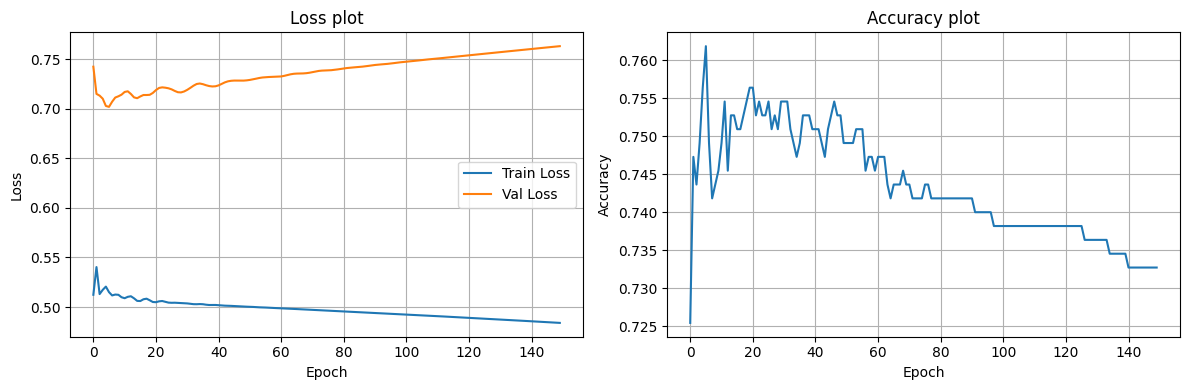

In [82]:
print("Training...")
train_losses, val_losses, val_acc = train_model_with_val(model, x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss plot')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(val_acc)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy plot')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Validate model.

Val accuracy: 72.00%
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       271
           1       0.36      0.25      0.29        56
           2       0.60      0.78      0.68       150
           3       0.62      0.17      0.27        29
           4       0.25      0.16      0.19        44

    accuracy                           0.72       550
   macro avg       0.55      0.46      0.47       550
weighted avg       0.70      0.72      0.70       550



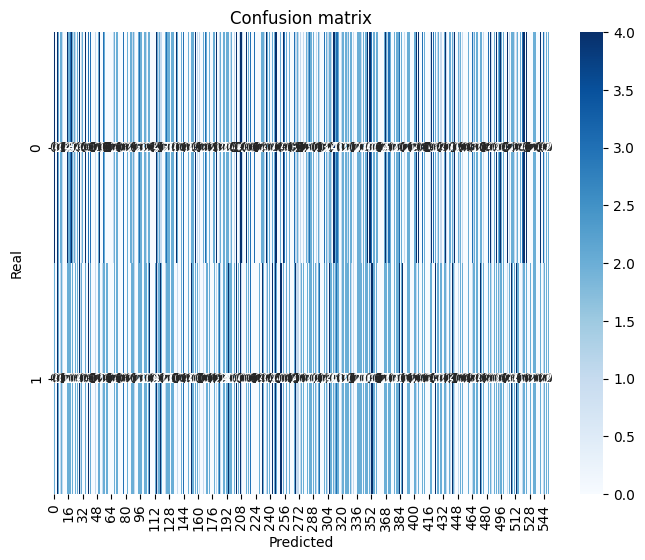

In [70]:
with torch.no_grad():
    model.eval()
    val_predictions = model(x_val_tensor)
    val_pred_classes = torch.argmax(val_predictions, dim=1)


accuracy = accuracy_score(y_val_tensor.numpy(), val_pred_classes.numpy())
print(f"Val accuracy: {accuracy*100:.2f}%")

print(classification_report(y_val, val_pred_classes.numpy()))

confMatrix = (y_val, val_pred_classes.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(confMatrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion matrix")
plt.ylabel("Real")
plt.xlabel("Predicted")
plt.show()

In [74]:
def train_model(model, x_train, y_train, epochs=200, lr=1e-3, print_epoch_every=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(epochs):
        model.train()
        predictions = model(x_train)

        loss = torch.nn.functional.cross_entropy(predictions, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if epoch % print_epoch_every == 0  or epoch == epochs - 1:
            print(f"Epoch: {epoch}; train loss={loss.item():.4f};")

    return train_losses

In [75]:
x_all_train, y_all_train = load_train_dataset(trainCsvPath, trainImagesPath)
x_all_train_tensor = torch.tensor(x_all_train, dtype=torch.float32)
y_all_train_tensor = torch.tensor(y_all_train, dtype=torch.long)


train_losses_all = train_model(model, x_all_train_tensor, y_all_train_tensor)

Loading train images...
Loaded 3662 size of train data
Epoch: 0; train loss=0.5646;
Epoch: 10; train loss=0.5687;
Epoch: 20; train loss=0.5641;
Epoch: 30; train loss=0.5619;
Epoch: 40; train loss=0.5604;
Epoch: 50; train loss=0.5591;
Epoch: 60; train loss=0.5578;
Epoch: 70; train loss=0.5565;
Epoch: 80; train loss=0.5551;
Epoch: 90; train loss=0.5537;
Epoch: 100; train loss=0.5523;
Epoch: 110; train loss=0.5507;
Epoch: 120; train loss=0.5492;
Epoch: 130; train loss=0.5475;
Epoch: 140; train loss=0.5459;
Epoch: 150; train loss=0.5442;
Epoch: 160; train loss=0.5424;
Epoch: 170; train loss=0.5406;
Epoch: 180; train loss=0.5388;
Epoch: 190; train loss=0.5369;
Epoch: 199; train loss=0.5351;


# Load and predict test data

In [76]:
def predict_test_dataset(model, csv_path, images_dir):
    df = pd.read_csv(csv_path)

    test_predictions_list = []
    test_ids = []

    print("Loading test images...")
    for idx, row in df.iterrows():
        img_filename = f"{row['id_code']}.jpg"
        img_path = os.path.join(images_dir, img_filename)

        try:
            img_vector = load_and_preprocess_image(img_path)

            img_tensor = torch.tensor(img_vector, dtype=torch.float32).unsqueeze(0)

            with torch.no_grad():
                prediction = model(img_tensor)
                pred_class = torch.argmax(prediction, dim=1).item()
            
            test_predictions_list.append(pred_class)
            test_ids.append(row['id_code'])
        except Exception as e:
            print(f"Error preprocessing image {img_path}: {e}")

            test_predictions_list.append(0)
            test_ids.append(row['id_code'])

    print(f"Loaded and predicted {len(x)} sized test data")

    return test_ids, test_predictions_list
            

In [77]:
test_ids, test_predictions = predict_test_dataset(
    model, 
    testCsvPath, 
    testImagesPath
)

Loading test images...


c:\Users\rost1\AppData\Local\Programs\Python\Python314\Lib\site-packages\kan\MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1857.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\rost1\AppData\Local\Programs\Python\Python314\Lib\site-packages\kan\MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1857.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\rost1\AppData\Local\Programs\Python\Python314\Lib\site-packages\kan\MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less tha

Loaded and predicted 3662 sized test data


# Create final file.

In [83]:
def create_file(test_ids, predictions, output_path="res.csv"):
    df = pd.DataFrame({'id_code': test_ids, 'diagnosis': predictions})
    
    df.to_csv(output_path, index=False)
    
    unique, counts = np.unique(predictions, return_counts=True)
    for cls, cnt in zip(unique, counts):
        print(f"  Class {cls}: {cnt} imgaes ({cnt/len(predictions)*100:.1f}%)")
    
    return df

In [86]:
df = create_file(test_ids, test_predictions)

print("\nFirst 10 rows:")
print(df.head(10))

  Class 0: 211 imgaes (10.9%)
  Class 1: 67 imgaes (3.5%)
  Class 2: 1405 imgaes (72.9%)
  Class 3: 164 imgaes (8.5%)
  Class 4: 81 imgaes (4.2%)

First 10 rows:
        id_code  diagnosis
0  0005cfc8afb6          2
1  003f0afdcd15          3
2  006efc72b638          2
3  00836aaacf06          2
4  009245722fa4          2
5  009c019a7309          2
6  010d915e229a          1
7  0111b949947e          0
8  01499815e469          2
9  0167076e7089          2


# Spline plot.

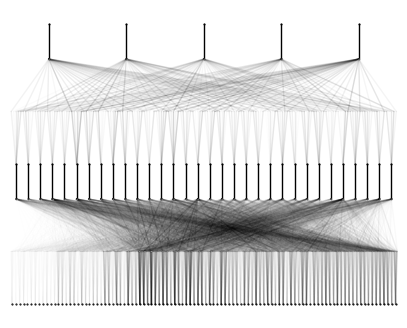

In [87]:
model.plot()